In [209]:
import numpy as np
import pandas as pd
import keras as k
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.callbacks import History
from keras.layers import Activation
from keras.models import model_from_json
from keras.optimizers import Adam
from matplotlib import pyplot as plt
np.random.seed(100)

In [190]:
file_path = '/Users/henok.s.mengistu/Documents/Henok\'s/Iceberg_challenge/data/processed/train.json'

In [210]:
train = pd.read_json(file_path)

In [192]:
print(train.head())
train.shape

                                              band_1  \
0  [-27.878360999999998, -27.15416, -28.668615, -...   
1  [-12.242375, -14.920304999999999, -14.920363, ...   
2  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2        id inc_angle  \
0  [-27.154118, -29.537888, -31.0306, -32.190483,...  dfd5f913   43.9239   
1  [-31.506321, -27.984554, -26.645678, -23.76760...  e25388fd   38.1562   
2  [-24.870956, -24.092632, -20.653963, -19.41104...  58b2aaa0   45.2859   
3  [-27.889421, -27.519794, -27.165262, -29.10350...  4cfc3a18   43.8306   
4  [-27.206915, -30.259186, -30.259186, -23.16495...  271f93f4   35.6256   

   is_iceberg  
0           0  
1           0  
2           1  
3           0  
4           0  


(1604, 5)

In [8]:
train[train['inc_angle'] == 'na'].count()

band_1        133
band_2        133
id            133
inc_angle     133
is_iceberg    133
dtype: int64

In [211]:
train.inc_angle = train.inc_angle.map(lambda x: 0.0 if x == 'na' else x)

In [272]:
from scipy import signal

xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
smooth = np.array([[1,1,1],[1,5,1],[1,1,1]])
xder2 = np.array([[-1,2,-1],[-3,6,-3],[-1,2,-1]])
yder2 = np.array([[-1,-3,-1],[2,6,2],[-1,-3,-1]])

In [276]:
def to_hypo(arr):
        arrx = signal.convolve2d(arr,xder,mode='valid')
        arry = signal.convolve2d(arr,yder,mode='valid')
        hypo = np.hypot(arrx,arry)
        return hypo
 

In [277]:
def transform (df):
    images = []
    for i, row in df.iterrows():
        band_1 = to_hypo(np.array(row['band_1']).reshape(75,75))
        band_2 = to_hypo(np.array(row['band_2']).reshape(75,75))
        band_3 = band_1 + band_2
        
        band_1_norm = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        band_2_norm = (band_2 - band_2. mean()) / (band_2.max() - band_2.min())
        band_3_norm = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())
        
        images.append(np.dstack((band_1_norm, band_2_norm, band_3_norm)))
    
    return np.array(images)

In [196]:
def augment(images):
    image_mirror_lr = []
    image_mirror_ud = []
    for i in range(0,images.shape[0]):
        band_1 = images[i,:,:,0]
        band_2 = images[i,:,:,1]
        band_3 = images[i,:,:,2]
            
        # mirror left-right
        band_1_mirror_lr = np.flip(band_1, 0)
        band_2_mirror_lr = np.flip(band_2, 0)
        band_3_mirror_lr = np.flip(band_3, 0)
        image_mirror_lr.append(np.dstack((band_1_mirror_lr, band_2_mirror_lr, band_3_mirror_lr)))
        
        # mirror up-down
        band_1_mirror_ud = np.flip(band_1, 1)
        band_2_mirror_ud = np.flip(band_2, 1)
        band_3_mirror_ud = np.flip(band_3, 1)
        image_mirror_ud.append(np.dstack((band_1_mirror_ud, band_2_mirror_ud, band_3_mirror_ud)))
        
    mirrorlr = np.array(image_mirror_lr)
    mirrorud = np.array(image_mirror_ud)
    images = np.concatenate((images, mirrorlr, mirrorud))
    return images

In [279]:
#plotting soem images
icebergs = train[train.is_iceberg ==1].sample(n=9,random_state =123)
ships = train[train.is_iceberg==0].sample(n=9,random_state=456)

iceberg_t = transform(icebergs)
ship_t = transform(ships)

print (iceberg_t.shape)
print (ship_t.shape)

(9, 73, 73, 3)
(9, 73, 73, 3)


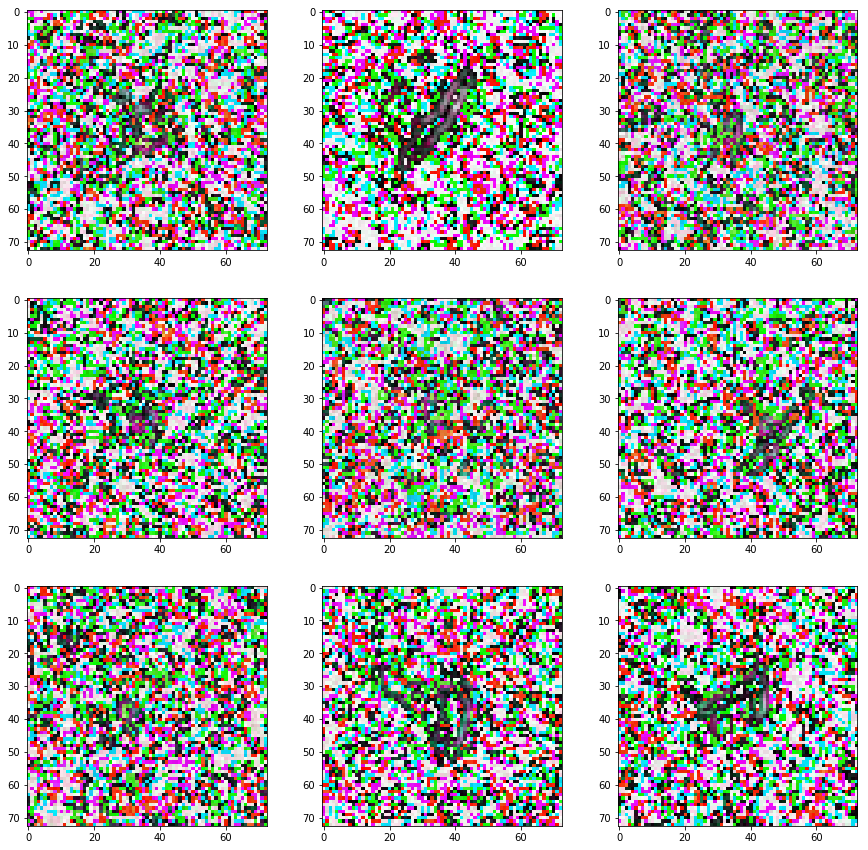

In [281]:
fig = plt.figure(1, figsize=(15,15))
for i in range (9):
    ax= fig.add_subplot(3,3,i+1)
    ax.imshow(iceberg_t[i])
plt.show()

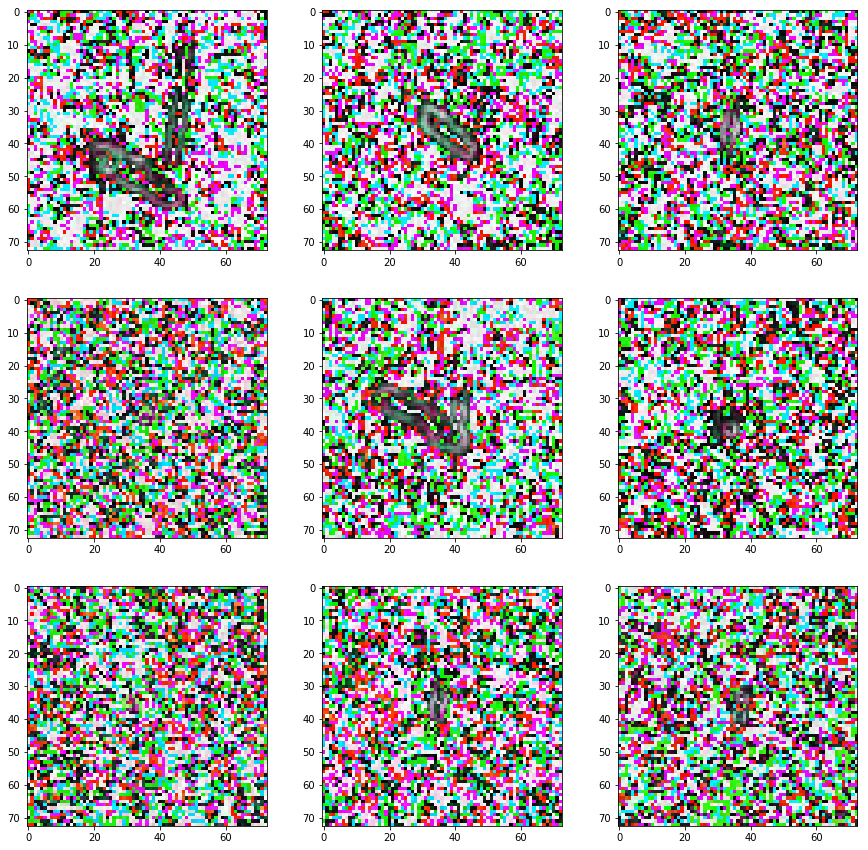

In [282]:
fig = plt.figure(1, figsize=(15,15))
for i in range (9):
    ax= fig.add_subplot(3,3,i+1)
    ax.imshow(ship_t[i])
plt.show()

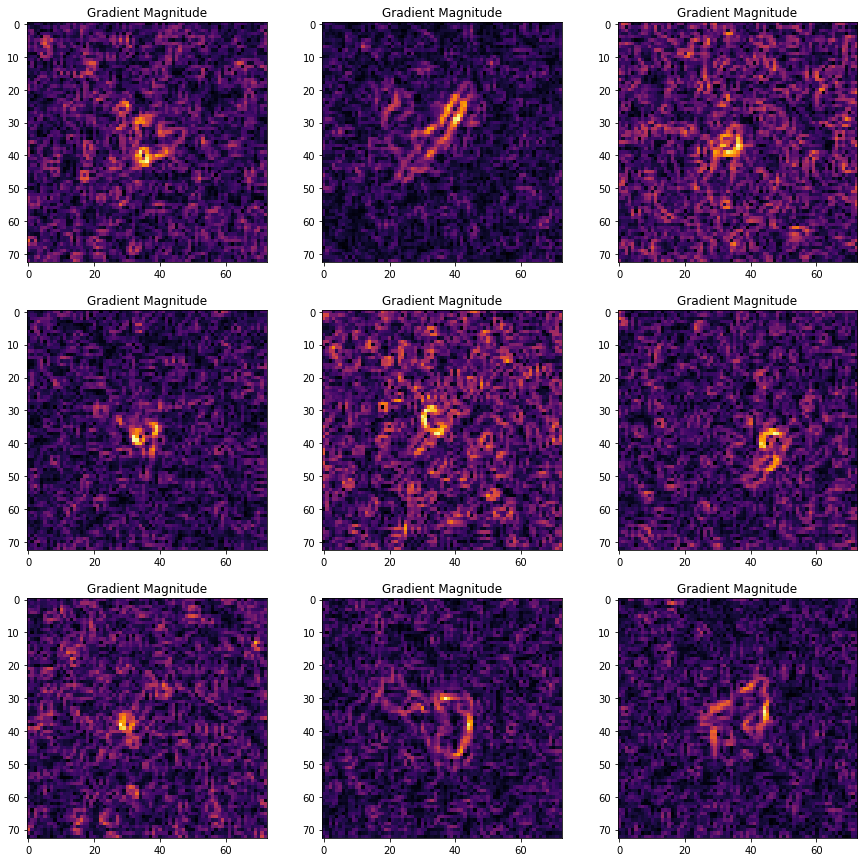

In [283]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]), (75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(icebergs.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

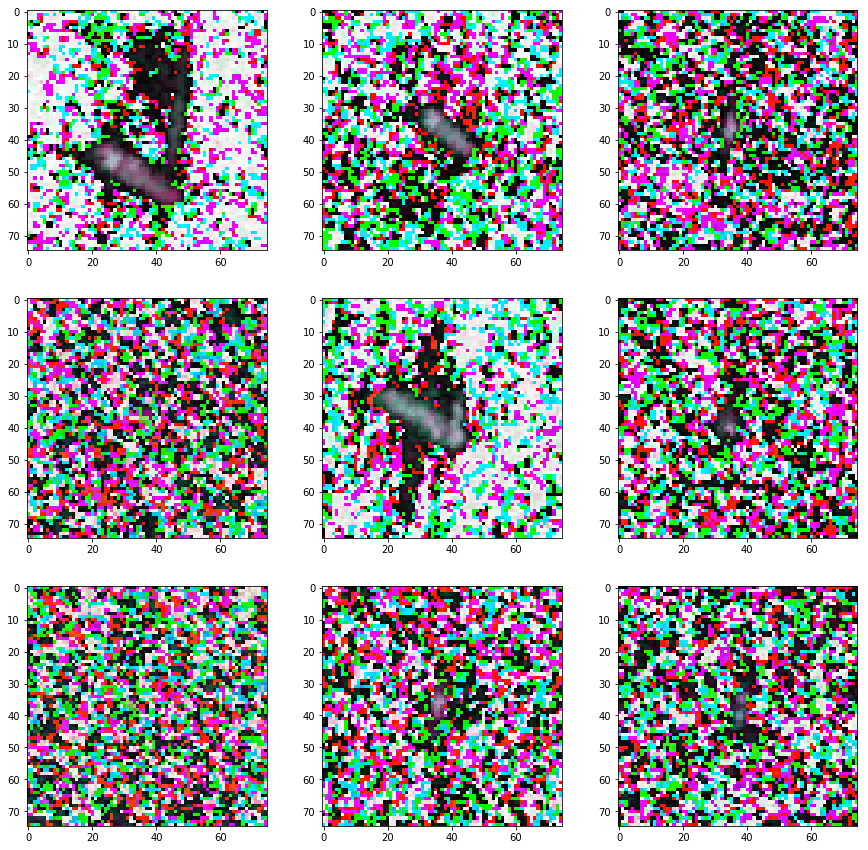

In [255]:
fig = plt.figure(1, figsize=(15,15))
for i in range (9):
    ax= fig.add_subplot(3,3,i+1)
    ax.imshow(ship_t[i])
plt.show()

ValueError: in1 and in2 should have the same dimensionality

In [ ]:
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arrx = ships.iloc[i,0]),(75,75)),xder,mode='valid')
    arry = signal.convolve2d(np.reshape(np.array(ships.iloc[i,0]),(75,75)),yder,mode='valid')
    ax.imshow(np.hypot(arrx,arry),cmap='inferno')
    ax.set_title('Gradient Magnitude')
    
plt.show()

In [285]:
train_X = transform(train)
train_y = np.array(train ['is_iceberg'])

indx_tr = np.where(train.inc_angle > 0)
print (indx_tr[0].shape)
train_y = train_y[indx_tr[0]]
train_X = train_X[indx_tr[0], ...]

train_X = augment(train_X)
train_y = np.concatenate((train_y,train_y, train_y))

print (train_X.shape)
print (train_y.shape)

(1471,)
(4413, 73, 73, 3)
(4413,)


In [30]:
x = np.array([1,2,3])
y = np.array([4,5,6])
z= np.array([7,8,9])
con = np.dstack((x,y,z))
print (con)

[[[1 4 7]
  [2 5 8]
  [3 6 9]]]


In [286]:
model = k.models.Sequential()

model.add(k.layers.convolutional.Conv2D(64, kernel_size=(3,3), input_shape=(73,73,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(k.layers.Dropout(0.2))


model.add(k.layers.convolutional.Conv2D(128, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(k.layers.Dropout(0.2))


model.add(k.layers.convolutional.Conv2D(128, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(k.layers.Dropout(0.3))


model.add(k.layers.convolutional.Conv2D(64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(k.layers.convolutional.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(k.layers.Dropout(0.3))


model.add(k.layers.Flatten())

model.add(k.layers.Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(k.layers.Dropout(0.2))

model.add(k.layers.Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(k.layers.Dropout(0.2))


model.add(k.layers.Dense(1))
model.add(Activation('sigmoid'))

mypotim=Adam(lr=0.1, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer = mypotim, metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 71, 71, 64)        1792      
_________________________________________________________________
activation_171 (Activation)  (None, 71, 71, 64)        0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_154 (Dropout)        (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 33, 33, 128)       73856     
_________________________________________________________________
activation_172 (Activation)  (None, 33, 33, 128)       0         
__________

In [288]:
batch_size = 64

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 0, mode= 'min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 5, verbose =1, 
                                   epsilon = 1e-4, mode='min', min_lr = 0.0001)
model_filepath='/Users/henok.s.mengistu/Documents/Henok\'s/Iceberg_challenge/weights.best_BN_After_hypo.hdf5'
checkpoint = ModelCheckpoint(model_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [early_stopping, checkpoint, reduce_lr_loss]

In [289]:
history = model.fit(train_X, train_y, batch_size = batch_size, epochs = 50, verbose =1, validation_split = 0.1, 
          callbacks=callbacks_list)

Train on 3971 samples, validate on 442 samples
Epoch 1/50
3971/3971 [==============================] - 147s - loss: 0.8694 - acc: 0.7356 - val_loss: 7.7673 - val_acc: 0.5181
Epoch 2/50
3971/3971 [==============================] - 132s - loss: 0.4388 - acc: 0.8074 - val_loss: 0.7741 - val_acc: 0.6471
Epoch 3/50
3971/3971 [==============================] - 139s - loss: 0.3982 - acc: 0.8300 - val_loss: 0.5391 - val_acc: 0.7534
Epoch 4/50
3971/3971 [==============================] - 132s - loss: 0.4761 - acc: 0.8111 - val_loss: 0.3522 - val_acc: 0.8529
Epoch 5/50
3971/3971 [==============================] - 136s - loss: 0.3319 - acc: 0.8512 - val_loss: 0.3394 - val_acc: 0.8552
Epoch 6/50
3971/3971 [==============================] - 134s - loss: 0.3514 - acc: 0.8456 - val_loss: 0.3490 - val_acc: 0.8462
Epoch 7/50
3971/3971 [==============================] - 138s - loss: 0.3730 - acc: 0.8396 - val_loss: 0.2767 - val_acc: 0.8824
Epoch 8/50
3971/3971 [==============================] - 134s - l

In [290]:
print (history.history.keys())
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
fig.savefig('performance.png')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


In [291]:
model_json = model.to_json()
with open("/Users/henok.s.mengistu/Documents/Henok\'s/Iceberg_challenge/model.json", "w") as json_file:
    json_file.write(model_json)

In [293]:
# load json and create model
json_file = open('/Users/henok.s.mengistu/Documents/Henok\'s/Iceberg_challenge/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/Users/henok.s.mengistu/Documents/Henok\'s/Iceberg_challenge/weights.best_BN_After_hypo.hdf5')
print("Loaded model from disk")
loaded_model.compile(loss='binary_crossentropy', optimizer = mypotim, metrics=['accuracy'])

Loaded model from disk


In [294]:
test_file = '/Users/henok.s.mengistu/Documents/Henok\'s/Iceberg_challenge/data-1/processed/test.json'
test = pd.read_json(test_file)
test.inc_angle = train.inc_angle.replace('na',0)
test_X = transform(test)
pred_test = loaded_model.predict(test_X, verbose=1)
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
submission.to_csv('/Users/henok.s.mengistu/Documents/Henok\'s/Iceberg_challenge/submission.csv', index=False)

8424/8424 [==============================] - 110s   
